In [ ]:
#test_plots
#plots containing spikes, spectrograms and hilbert transform for visual inspestion

In [1]:
from database.db_setup import *
import preprocessing.data_preprocessing.binning as binning
import preprocessing.data_preprocessing.create_vectors_from_time_points as create

config


Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306
Epiphyte Setup


In [2]:
"""
Functions for plotting the screening results. 
Adapted from Johannes Niediek's original standalone code to interface withe database 
"""

import scipy.signal
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# local imports
from database.db_setup import *

from visualization.scr_utils import *
import analysis.stats_code.compute_pvalues as cp

# constants 

EMPTY = np.array([])
OUTFOLDER = 'pvalues'

PVAL_CUTOFF = .1
MIN_ACTIVE_TRIALS = 3

FIGSIZE = (12, 12)
T_PRE = 1000
T_POST = 2000
HIST_BIN_WIDTH = 100
HIST_BINS = np.arange(-T_PRE, T_POST + 1, HIST_BIN_WIDTH)

POSITIONS = ('pre', 'post')
COLORS = ('blue', 'green')

DPI = 200


#################################
## Screening Plotting Functions #
#################################


def plot_one_raster(plot, plot_hist, sp_times, event_data, pvalues, amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post):
    
    sep = .2
    hist_max = 0
    time_data = []
    color_data = []
    hist_data = defaultdict(list)
    
    for name, color in zip(POSITIONS, COLORS):
        events = event_data.loc[event_data.position == name, 'time'].values
        for event in events:
            idx_sp = (sp_times >= event - T_PRE) & (sp_times <= event + T_POST)
            if idx_sp.any():
                temp = sp_times[idx_sp] - event

                time_data.append(temp)
                t_hist, _ = np.histogram(temp, HIST_BINS)

                hist_data[name].append(t_hist * 1000 / HIST_BIN_WIDTH)
            else:
                time_data.append([-2*T_PRE])   # hack of eventplot

            color_data.append(color)

    # immediately plot the histogram
    for name, color in zip(POSITIONS, COLORS):
        if len(hist_data[name]):
            hist = np.vstack(hist_data[name]).mean(0)
            hist_max = np.max((hist.max(), hist_max))
            plot_hist.bar(HIST_BINS[:-1], hist, width=HIST_BIN_WIDTH, facecolor=color,
                lw=0, alpha=.5)

    plot.eventplot(time_data, color=color_data, lw=1)
    plot_hist.set_xticks((0, 1000))
    
    #add hilbert transform
    times = np.linspace(-0.5, 1, 1500)
    times = times*1000
    plot2 = plot.twinx()
    plot_hist2 = plot_hist.twinx()
    plot2.plot(times, amplitude_envelope_pre, color='blue', linewidth=0.5)
    plot2.plot(times, amplitude_envelope_post, color='green', linewidth=0.5)
    plot_hist2.plot(times, amplitude_envelope_pre, color='blue', linewidth=0.5)
    plot_hist2.plot(times, amplitude_envelope_post, color='green', linewidth=0.5)
    
    for pos in ('bottom', 'top', 'right'):
        plot.spines[pos].set_visible(False)
        plot_hist.spines[pos].set_visible(False)
        plot_hist2.spines[pos].set_visible(False)

    plot.axis('off')
    plot2.axis('off')
    plot_hist2.axis('off')

    for pos in (0, 1000):
        for pl in (plot, plot_hist):
            pl.axvline(pos, ls='--', color='k', lw=1, alpha=.8)

    plot.set_xlim((-T_PRE, T_POST))
    plot.set_ylim((-.5, len(time_data) + .5))
    plot.set_yticks([])
    plot.set_xticks((0, 1000))
    plot.set_xticklabels([])

    has_response = {}

    for name, namecolor in zip(POSITIONS, COLORS):
        has_response[name] = False
        idx = pvalues.position == name
        assert idx.sum() == 1

        if name == 'pre':
            xpos = -.05
            ha = 'left'
        elif name == 'post':
            xpos = 1.05
            ha = 'right'

        active_t = pvalues.loc[idx, 'active_trials'].values[0]

        #### here, modify the pvalues shown. 
        ## before doing so, make sure it'd be worth it by comparing 
        ## the bwsr and the perm pvalue results
        for short_name, value_name, ypos in zip(('BW', 'SCR', 'A'),
                ('pval_bwsr', 'pval_scr', 'active_trials'),
                (1, 1 + sep, 1 + 2 * sep)):
            value = pvalues.loc[idx, value_name].values[0]
            color = 'k'
            if short_name in ('BW', 'SCR'):
                my_format = '.4f'
                # print(value, active_t)
                if (value < PVAL_CUTOFF) and (active_t > MIN_ACTIVE_TRIALS):
                    color = 'g'
                    has_response[name] = True
            else:
                my_format = 'd'

            title = format(value, my_format)

            if name == 'pre':
                title = short_name[0] + ' ' + title

            plot.text(xpos, ypos, title, color=color, transform=plot.transAxes, ha=ha, va='bottom', size=7)

        plot.text(xpos, 1 + 3 * sep, name, ha=ha, va='bottom', size=9, transform=plot.transAxes, color=namecolor)
 
    ret_val = False
    if has_response['pre'] or has_response['post']:
        if has_response['pre'] and has_response['post']:
            color = 'green'
        elif has_response['pre'] and not has_response['post']:
            color = 'blue'
        elif not has_response['pre'] and has_response['post']:
            color = 'red'
            ret_val = True

        rect = Rectangle((0, 0), 1, 1, edgecolor=color, transform=plot.transAxes,
            lw=4, facecolor='none')
        plot.add_patch(rect)

    # return whether this is an interesting example (additional response)
    return ret_val, hist_max


def plot_one_unit(fig, grid, title, stim_frame, spikes, unit_pvals, stim_data, ch, ch_site, filtering_type):
    """
    stim_data is a filename -> (a, b, c, d) dictionary, where
    a: stim_num
    b: stim_name
    c: paradigm
    d: image
    """

    all_hists = []
    times = spikes
    save_unit = False

    info_plot = fig.add_axes([0, .9, .8, .1])
    info_plot.axis('off')

    num_stimuli = len(np.unique(stim_frame["filename"]))
    
    if num_stimuli == 42:
        img_order = IMAGE_ORDER_ALL
    elif num_stimuli == 35:
        img_order = IMAGE_ORDER_NO_TEXT
    else: 
        raise Exception("Irregular number of stimuli for patient.")
    
    for i_row, row in enumerate(img_order):
        for i_col, img_fname in enumerate(row):
            stim_num, stim_name, paradigm, image = stim_data[img_fname]
            #stim_idx and stim_name
            
            folder=f'05-Hilbert_transform_{patient_id}'
            norm_type = 'zscore'
            if stim_name == '???':
                ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_pre.npy')
                ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_post.npy')
            else:
                ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_pre.npy')
                ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_post.npy')
            std_pre = np.std(ampl_envelope_pre,axis=0)
            std_post = np.std(ampl_envelope_post,axis=0)            
            
            amplitude_envelope_pre = np.mean(ampl_envelope_pre, axis=0)
            amplitude_envelope_post = np.mean(ampl_envelope_post, axis=0)
            
            #DOWNSAMPLE
            amplitude_envelope_pre = scipy.signal.resample(amplitude_envelope_pre, 1500)
            amplitude_envelope_post = scipy.signal.resample(amplitude_envelope_post, 1500)
            
            
            
            plot = fig.add_subplot(grid[3 * i_row, i_col])
            plot.axis('off')

            # show the image
            if paradigm == 'scr' :
                plot.imshow(image)
                plot.text(.5, 1, stim_name, transform=plot.transAxes,
                    va='bottom', ha='center', size=6)

            else:
                plot.text(.5, .5, stim_name, transform=plot.transAxes,
                    va='center', ha='center')

            # make the raster and histogram
            plot = fig.add_subplot(grid[3 * i_row + 1, i_col])
            plot_hist = fig.add_subplot(grid[3 * i_row + 2, i_col])

            if i_col > 0:
                plot_hist.set_yticklabels([])

            else:
                plot_hist.set_ylabel('Hz')

            if i_row + 1 < len(img_order):
                plot_hist.set_xticklabels([])
            
            # generate the raster plot for one stimulus
            # plot_one_raster(plot, plot_hist, sp_times, event_data, pvalues)
            is_interesting, hist_max = plot_one_raster(plot, plot_hist,
                    times, stim_frame.loc[stim_frame.stim_num == stim_num, ['position', 'time']],
                    unit_pvals.loc[unit_pvals.stim_num == stim_num, :], amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post)
            
            if is_interesting:
                save_unit = True

            all_hists.append(plot_hist)

    info_plot.text(.5, .5, title, va='center', ha='center', size=12)
    if save_unit:
        rect = Rectangle((0, .25), .1, .5, facecolor='red', edgecolor='none',
            transform=info_plot.transAxes, alpha=.5)
        info_plot.add_patch(rect)

    # rescale the maximum
    for plot in all_hists:
        plot.set_ylim((0, hist_max * 1.1))
        plot.set_yticks((0, round(hist_max)))

    return save_unit

def run_one_channel(fig, save_folder, grid, frame, channel, ch_site, patient_id, session_nr, stim_data, filtering_type):
    """
    load the pvalues and units for one channel, one sorting, and iterate over the units
    """
    
    # get all units from a single channel
    channel_units = get_unit_ids_in_channel(patient_id, session_nr, channel)
    
    for unit in channel_units:
        print("    Running unit {}..".format(unit))


        ### calculate pvalues for a unit 
        spikes = get_spiking_activity(patient_id, session_nr, unit)
        
        stim_index, eventtimes = get_scr_eventtimes(patient_id, session_nr)

        region = get_brain_region(patient_id, unit)
        unit_type = get_unit_type(patient_id, session_nr, unit)
    
        title = "{:03d}mv1 Unit #{}, Channel: {} ({})".format(patient_id, unit, channel, unit_type)

        unit_pvals = get_scr_stats_as_df(patient_id, session_nr, unit)
        
        print("    Total spikes: {}".format(len(spikes)))
        
        fig.clf()
                 
        #print(frame)
        is_interesting = plot_one_unit(fig, grid, title, frame, spikes, unit_pvals, stim_data, channel, ch_site, filtering_type)


        fname = '{:03d}mv1_CSC{:02d}_{}_unit{:03d}.jpeg'.format(patient_id,
                channel, unit_type, unit)

        fig.savefig(os.path.join(save_folder, fname), dpi=DPI, transparent=False)

        if is_interesting:
            with open(os.path.join(save_folder, 'interesting.txt'), 'a') as fid:
                fid.write(fname + '\n')
            fid.close()
            
def run_session(df_patient_info, patient_id, filtering_type):
    """
    load stimulus frame and channel list for one session
    """  
    session_nr = get_session_info(patient_id)
    
    assert isinstance(session_nr, int), "More than one session for patient {}. Code currently not set up for automatically running multiple sessions from a single patient.".format(patient_id)
    
    position, stim_id, filename, stim_name, is_500_days, paradigm, time = get_screening_data(patient_id, session_nr)
    frame = cp.make_dataframe(position, stim_id, filename, stim_name, is_500_days, paradigm, time)

    stim_data = {}
    stim_nums = frame.stim_num.unique()

    for stim_num in stim_nums:
        # setting up to get the stimulus image
        meta = frame.loc[frame.stim_num == stim_num, :].iloc[0]
        stim_fname = meta["filename"]
        stim_data[stim_fname] = (stim_num,
                                meta["stim_name"],
                                meta["paradigm"],
                                mpl.imread(os.path.join(PATH_TO_IMAGES, stim_fname))) ## read image file into an array

    fig = mpl.figure(figsize=FIGSIZE)
    grid = GridSpec(18, 7, left=.06, right=.98, top=.9, bottom=.04)

    # init saving directory 
    PATH_TO_PLOTS = f'/home/anastasia/epiphyte/anastasia/output/07-screenings_{patient_id}'
    save_folder = os.path.join(PATH_TO_PLOTS, filtering_type)
        #'screenings', '{:03d}'.format(patient_id))
                               
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    all_channels = get_cscs_for_patient(patient_id, session_nr)
        
    for channel in all_channels:
        print("Running channel {}...".format(channel))
        ch_site = df_patient_info.loc[channel-1,'recording_site']
        run_one_channel(fig, save_folder, grid, frame, channel, ch_site, patient_id, session_nr, stim_data, filtering_type)

    mpl.close(fig)

Running channel 1...
    Running unit 0..
    Total spikes: 13


/home/anastasia/anaconda3/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


Running channel 2...
    Running unit 1..
    Total spikes: 16100


KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

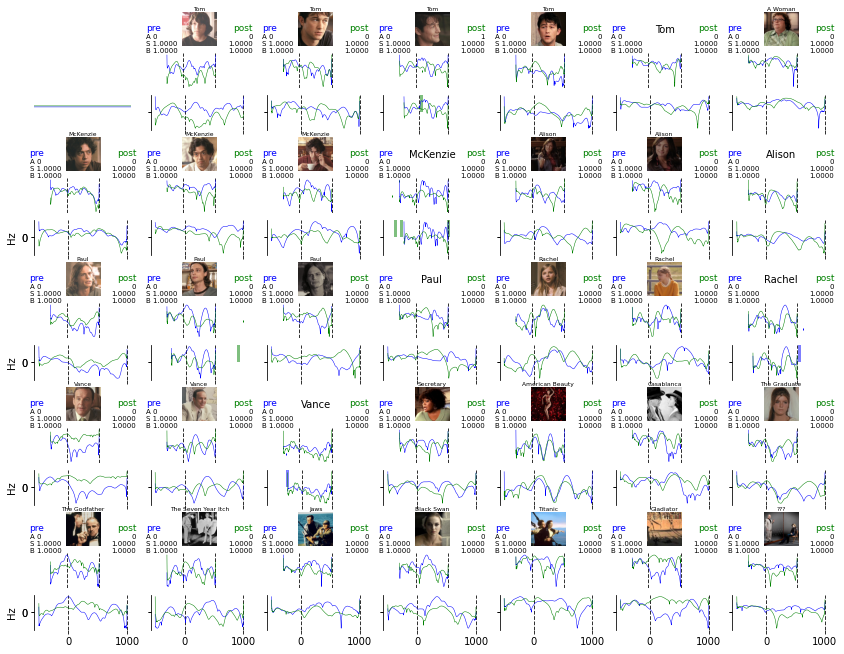

In [3]:
top_dir = '/home/anastasia/epiphyte/anastasia/output'
patient_id = 46
df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')

fig = mpl.figure(figsize=FIGSIZE)
run_session(df_patient_info, patient_id=patient_id, filtering_type='theta')